In [53]:
import numpy as np
import cv2

# Punto 1

In [54]:
densidad = 150000 #unidades/mm2
area_cono = 1/densidad

#si asumimos que los conos son "cuadrados", el lado del cono es L=sqrt(area_cono)
#fuente: a checkear --> Distancia focal a 30cm = 15,8mm


image_size = np.sqrt(area_cono)/15.8 * 300
print(f"tamaño mínimo: {image_size:.04f} mm")

# Sabiendo que la densidad de pixeles de un Motorola Edge 30 es aprox 405 pixeles por pulgada:
densidad_lineal_moderno = 405/25.4 #esto nos da la densidad "lineal" de pixeles por mm
pixel_size = 1/densidad_lineal_moderno
print(f"Tamaño de pixel moderno: {pixel_size:.04f} mm")

tamaño mínimo: 0.0490 mm
Tamaño de pixel moderno: 0.0627 mm


Tiene sentido que el pixel sea más grande que el tamaño mínimo, para poder distinguir las imágenes en el celular.

# Punto 2
## Consideraciones
- Como el detector es cuadrado, consideramos que la representación de la imagen también
    - Esto lleva a que 1MP = 1000P * 1000P, así se tiene un "lado" de imagen de 1000 pixeles.

In [55]:
altura_detector = 10 # CCD de 10x10mm
cant_pixeles = 1e6 #1MP
lado_en_pixeles = 1000
distancia = 1000 #1m en mm

distancia_real = 10/35 * 1000 #Todo en milímetros, sale de semejanza de triángulos
distancia_por_pixel = distancia_real / lado_en_pixeles

print(f"La distancia que representa el ancho de un pixel es {distancia_por_pixel:.04f}mm")

La distancia que representa el ancho de un pixel es 0.2857mm


# Punto 3

# Punto 4

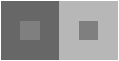

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Crear dos bloques de 9x9
imagen = np.zeros((9, 18))

# Fondo del bloque izquierdo
imagen[:, :9] = 103

# Fondo del bloque derecho
imagen[:, 9:] = 183

# Cuadrado central gris
imagen[3:6, 3:6] = 127     # Cuadrado en el bloque oscuro
imagen[3:6, 12:15] = 127   # Cuadrado en el bloque claro

# Mostrar imagen ampliada sin bordes
plt.figure(figsize=(9, 4.5), dpi=13)
plt.imshow(imagen, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

#con izq=63, der=223
    #para mí, se ven iguales con 145 en el lado derecho
#con izq=33, der=243
    #se ven iguales con 135 del lado derecho.
#con izq=83, der=203
    #se ven iguales con 150 del lado derecho.

#conclusiones
    # Mientras más cercanos entre sí los colores de fondo, más diferencia debe haber entre los
    # colores de los centros para percibirlas iguales

    # Siguiendo una misma línea, mientras más distantes los colores de fondo, menor es la diferencia
    # entre colores de centro

    #Esto puede explicarse con el comportamiento "pasa bajos" del ojo humano, que intenta "promediar"
    #las intensidades. Por lo tanto, mientras más contraste, más "fácil" es para el ojo distinguir los colores
    #y menos diferencia de color en el centro se requiere.

    #Mientras menos contraste haya, más "le cuesta" al ojo distinguir el color.



    #Interpreto que esta diferencia de colores es un producto del contraste que tienen los cuadraditos, ya que
    # al tener una gran diferencia de colores entre el borde y el centro se ve una zona fronteriza donde se ve 
    # una combinación de colores que parece crear una ilusión de profundidad, al ser imagenes chicas predomina más 
    # la zona fronteriza que el centro, por lo que se ve una diferencia de colores entre cada cuadradito



# Punto 5

In [57]:
import cv2
import numpy as np

img = cv2.imread('mono.bmp', cv2.IMREAD_GRAYSCALE)  # Leer en escala de grises
h, w = img.shape
decim_a = img[1::4, 1::4]  # Interpreto que la consigna toma los puntos contando desde 1,1

decim_b = img[0::4, 0::4]

decim_c = np.zeros((h // 4, w // 4), dtype=np.uint8)
for i in range(0, h, 4):
    for j in range(0, w, 4):
        block = img[i:i+4, j:j+4]
        decim_c[i//4, j//4] = np.mean(block).astype(np.uint8)

def bilinear_interpolation(im, scale):
    h, w = im.shape
    new_h, new_w = h * scale, w * scale
    result = np.zeros((new_h, new_w), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            x = i / scale
            y = j / scale

            x0 = int(x)
            x1 = min(x0 + 1, h - 1)
            y0 = int(y)
            y1 = min(y0 + 1, w - 1)

            dx = x - x0
            dy = y - y0

            result[i, j] = (
                im[x0, y0] * (1 - dx) * (1 - dy) +
                im[x1, y0] * dx * (1 - dy) +
                im[x0, y1] * (1 - dx) * dy +
                im[x1, y1] * dx * dy
            ).astype(np.uint8)

    return result

interp_a = bilinear_interpolation(decim_a, 4)
interp_b = bilinear_interpolation(decim_b, 4)
interp_c = bilinear_interpolation(decim_c, 4)



In [58]:
import numpy as np

# Kernel bicúbico de Keys (Catmull-Rom si a = -0.5)
def cubic_kernel(t, a=-0.5):
    """
    Calcula el peso del píxel a distancia t usando el kernel bicúbico.
    t: distancia entre píxeles (puede ser fraccionaria)
    a: parámetro de forma (Catmull-Rom = -0.5)
    """
    t = abs(t)
    if t <= 1:
        return (a + 2) * t**3 - (a + 3) * t**2 + 1
    elif t < 2:
        return a * t**3 - 5*a * t**2 + 8*a * t - 4*a
    else:
        return 0

# Interpolación 1D
def interpolate_1d(pixels, x):
    """
    Interpolación cúbica 1D sobre 4 puntos.
    pixels: lista o array con 4 valores de píxeles.
    x: desplazamiento fraccional desde el segundo punto (p[1]).
    """
    return (pixels[0] * cubic_kernel(x + 1) +
            pixels[1] * cubic_kernel(x) +
            pixels[2] * cubic_kernel(x - 1) +
            pixels[3] * cubic_kernel(x - 2))

# Interpolación bicúbica 2D
def bicubic_resize(img, scale):
    """
    Redimensiona una imagen usando interpolación bicúbica manual.
    img: np.ndarray (2D en escala de grises)
    scale: factor de escala (>1 para agrandar, <1 para reducir)
    """
    h, w = img.shape
    new_h = int(h * scale)
    new_w = int(w * scale)

    # Imagen resultado vacía
    output = np.zeros((new_h, new_w), dtype=np.float32)

    for y in range(new_h):
        for x in range(new_w):
            # Coordenadas en la imagen original (flotantes)
            gx = x / scale
            gy = y / scale

            # Parte entera de la coordenada
            ix = int(np.floor(gx))
            iy = int(np.floor(gy))

            # Parte fraccionaria
            dx = gx - ix
            dy = gy - iy

            # Guardaremos 4 valores interpolados horizontalmente
            col_vals = []
            for m in range(-1, 3):
                # Fila de 4 píxeles vecinos en horizontal
                row_vals = []
                for n in range(-1, 3):
                    px = min(max(ix + n, 0), w - 1)  # Clamping en X
                    py = min(max(iy + m, 0), h - 1)  # Clamping en Y
                    row_vals.append(img[py, px])
                
                # Interpolación horizontal en esta fila
                col_vals.append(interpolate_1d(row_vals, dx))

            # Interpolación vertical usando los 4 valores obtenidos
            output[y, x] = interpolate_1d(col_vals, dy)

    # Limitar valores a rango válido [0, 255]
    return np.clip(output, 0, 255).astype(np.uint8)

In [59]:
interp_bicubica_a = bicubic_resize(decim_a, 4)
interp_bicubica_b = bicubic_resize(decim_b, 4)
interp_bicubica_c = bicubic_resize(decim_c, 4)

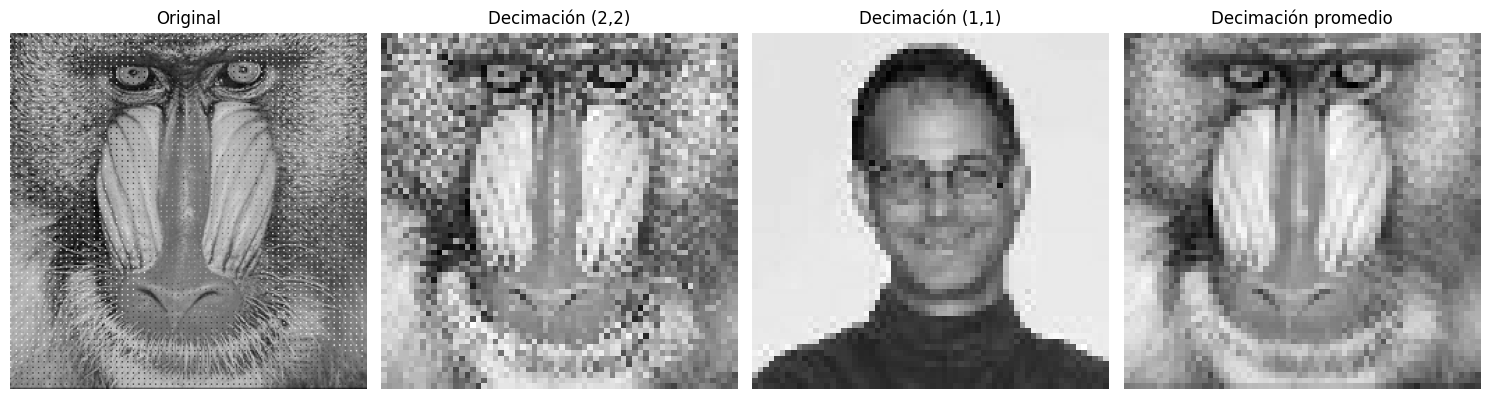

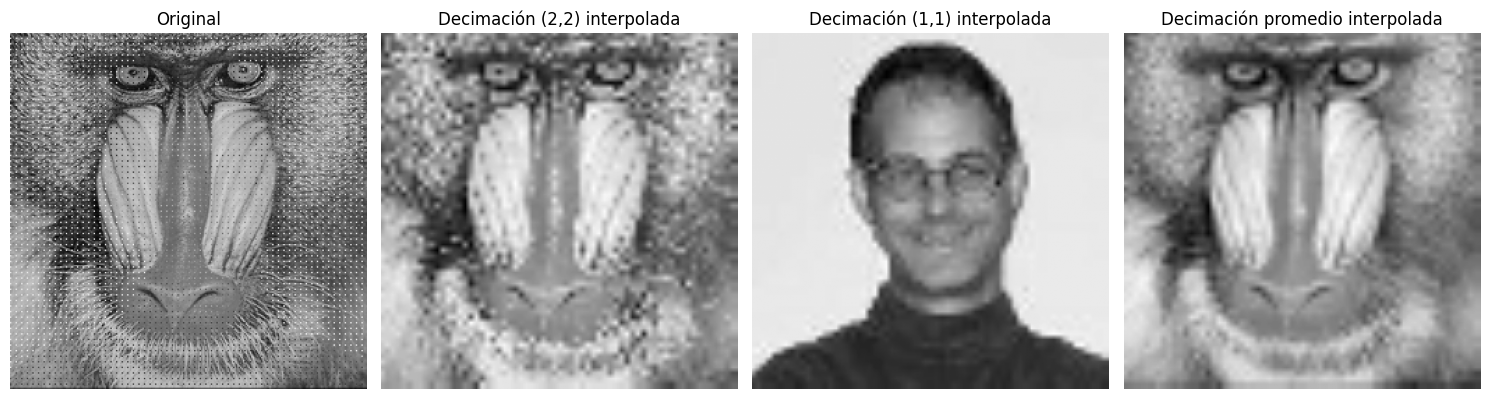

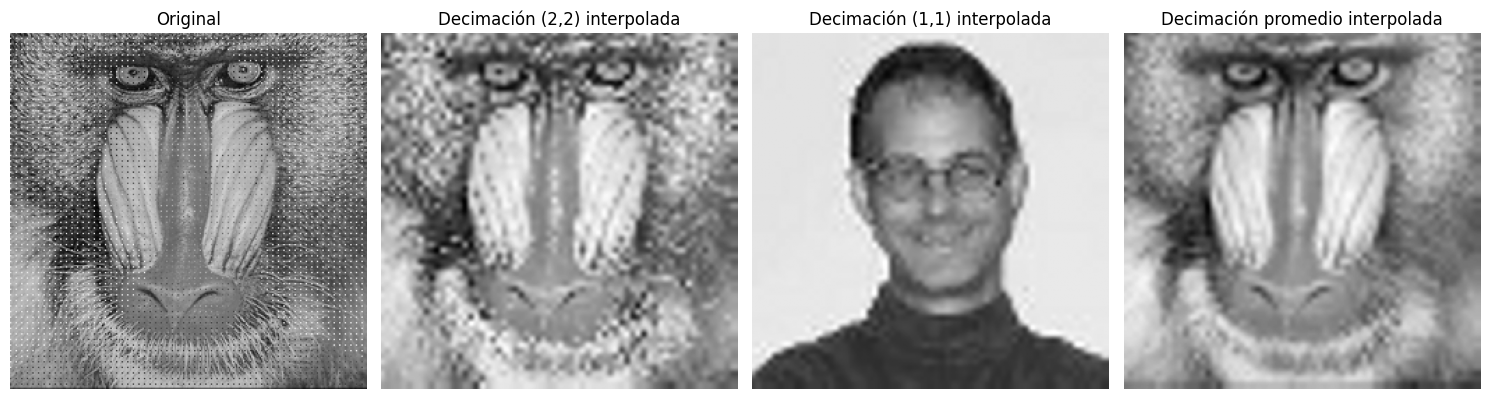

In [60]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(decim_a, cmap='gray')
plt.title('Decimación (2,2)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(decim_b, cmap='gray')
plt.title('Decimación (1,1)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(decim_c, cmap='gray')
plt.title('Decimación promedio')
plt.axis('off')

plt.tight_layout()
plt.show()

#Interpolaciones bilineales
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(interp_a, cmap='gray')
plt.title('Decimación (2,2) interpolada')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(interp_b, cmap='gray')
plt.title('Decimación (1,1) interpolada')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(interp_c, cmap='gray')
plt.title('Decimación promedio interpolada')
plt.axis('off')

plt.tight_layout()
plt.show()

#Interpolaciones bicubicas
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(interp_bicubica_a, cmap='gray')
plt.title('Decimación (2,2) interpolada')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(interp_bicubica_b, cmap='gray')
plt.title('Decimación (1,1) interpolada')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(interp_bicubica_c, cmap='gray')
plt.title('Decimación promedio interpolada')
plt.axis('off')

plt.tight_layout()
plt.show()

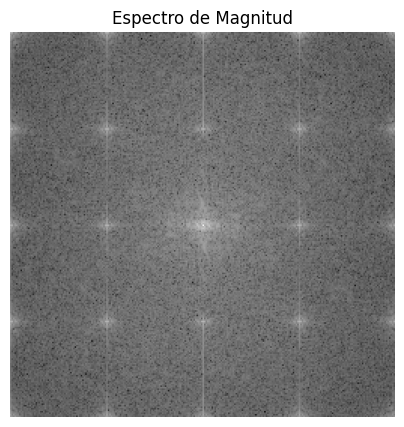

In [64]:
import matplotlib.pyplot as plt

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

plt.figure(figsize=(5, 5))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Espectro de Magnitud')
plt.axis('off')
plt.show()
